# CNI 2015 - Spring, Seattle

The following is code to generate graphs for the SHARE presentation.

# Setup

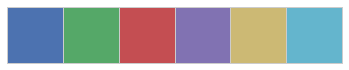

In [132]:
%matplotlib inline

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
current_palette = sns.color_palette()
sns.palplot(current_palette)

import requests
requests.packages.urllib3.disable_warnings()

OSF_APP_URL = 'https://osf.io/api/v1/share/search/?raw=True&v=1'

def as_dict(key, agg):
    d = {}
    if 'buckets' in agg['aggregations']['agg']:
        pairs = agg['aggregations']['agg']['buckets']
    else:
        pairs = agg['aggregations']['agg']['next']['buckets']
    for pair in pairs:
        d[pair['key']] = { key: pair['doc_count'] }
    return d#{pair['key']:{key:pair['doc_count']} for pair in agg['aggregations']['agg']['buckets']}

def query(q):
    a = {
        'size': 0,
        'aggs': q
    }
    response = requests.post(OSF_APP_URL, json=a, verify=False)
    return response.json()

def agg(key, q):
    return as_dict(key, query({"agg": q}))

def merge(d1, d2):
    for k,v in d2.items():
        if k in d1:
            for k2,v2 in v.items():
                d1[k][k2] = v2
        else:
            d1[k] = v
    return d1

def merge(df, a):
    return df.merge(
        pd.DataFrame.from_dict(a, 'index'),
        left_index=True, right_index=True
    )

## Load aggregation queries

In [133]:
agg_total = {
    "terms": {
        "min_doc_count": 0, 
        "size": 0, 
        "field": "source"
    }
}

agg_no_doi = { 
    "aggs": {
        "next": {
            "terms": {
                "min_doc_count": 0, 
                "size": 0, 
                "field": "source"
            }, 
        }
    },
    "filter": {
        "query": {
            "query_string": {
                "query": "NOT doi:*"
            }
        }
    }
}

agg_no_title = { 
    "aggs": {
        "next": {
            "terms": {
                "min_doc_count": 0, 
                "size": 0, 
                "field": "source"
            }, 
        }
    },
    "filter": {
        "query": {
            "query_string": {
                "query": "NOT title:*"
            }
        }
    }
}

top_tags = {"tagsTermFilter": {"terms": {"size": 10, "field": "tags", "exclude": "of|and|or"}}, "allSourceAgg": {"terms": {"min_doc_count": 0, "size": 0, "field": "source"}}}

## Aggregate Total Documents by Provider

In [134]:
data = agg('total', agg_total)
df = pd.DataFrame.from_dict(data, 'index')

## Aggregate DOI Count by provider

In [135]:
df = merge(df, agg('no_doi', agg_no_doi))
df['percent_doi'] = (df['total']-df['no_doi'])/df['total']*100

## Aggregate Title Count by Provider

In [136]:
df = merge(df, agg('no_title', agg_no_title))
df['percent_title'] = (df['total']-df['no_title'])/df['total']*100

# Summary

## Percentage Titles

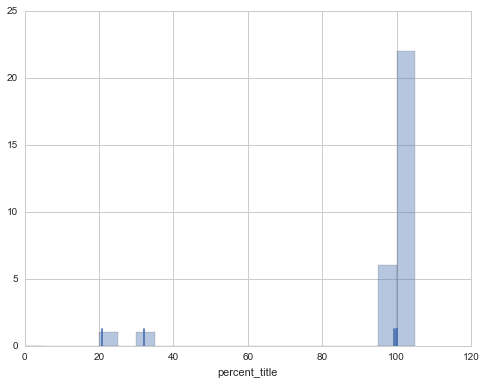

In [141]:
plt.figure(figsize=(8, 6))
sns.distplot(df['percent_title'], rug=True, kde=False, bins=np.arange(0, 105.1, 5))

## Percentage DOIs

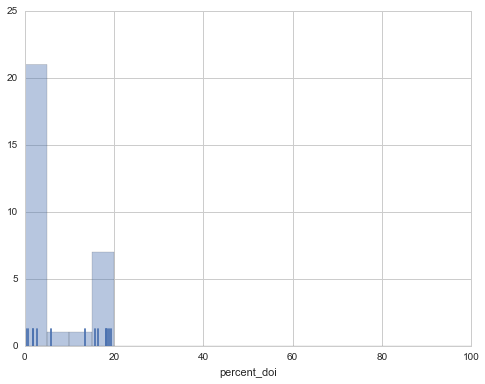

In [142]:
plt.figure(figsize=(8, 6))
sns.distplot(df['percent_doi'], rug=True, kde=False, bins=np.arange(0, 105, 5))

## Top 10 Tags

In [143]:
query({"tagsTermFilter": {"terms": {"size": 10, "field": "tags", "exclude": "of|and|or"}}})

{'_shards': {'failed': 0, 'successful': 5, 'total': 5},
 'aggregations': {'tagsTermFilter': {'buckets': [{'doc_count': 16057,
     'key': 'water'},
    {'doc_count': 15492, 'key': 'health'},
    {'doc_count': 15119, 'key': 'california'},
    {'doc_count': 14826, 'key': 'county'},
    {'doc_count': 14373, 'key': 'drinking'},
    {'doc_count': 14368, 'key': 'contaminants'},
    {'doc_count': 10902, 'key': 'physics'},
    {'doc_count': 9580, 'key': 'science'},
    {'doc_count': 8367, 'key': 'article'},
    {'doc_count': 5987, 'key': 'energy'}],
   'doc_count_error_upper_bound': 2062,
   'sum_other_doc_count': 692407}},
 'hits': {'hits': [], 'max_score': 0.0, 'total': 617663},
 'time': 0.1,
 'timed_out': False,
 'took': 86}

## The Data

In [ ]:
df